In [76]:
# !pip install qiskit
# !pip install numpy
# !pip install matplotlib
# !pip install fractions
# !pip install --upgrade qiskit
# !pip install pylatexenc
# !pip install qiskit-aer
# !pip install qiskit-ibm-runtime

In [77]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from math import gcd
from fractions import Fraction
import numpy as np

In [78]:
N_value = 21
N_WORKING_QUBITS = 5 # 2^5 
N_PHASE_ESTIMATION_QUBITS = 10 # precision up tp 2^-10
a = [2, 10, 19] # 4, 10, 19 values chosen for the project

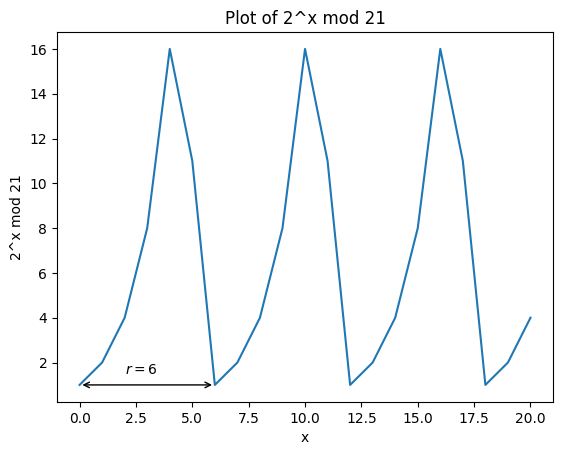

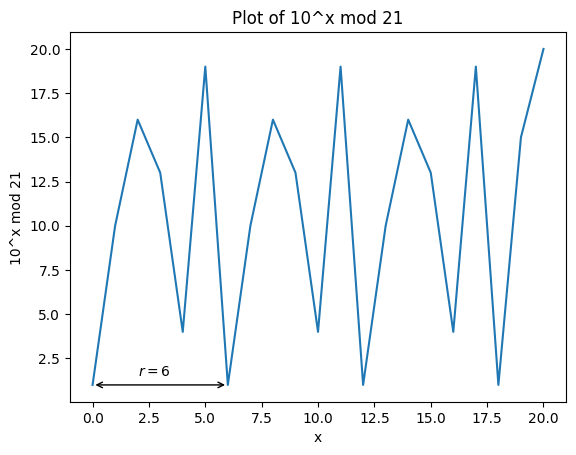

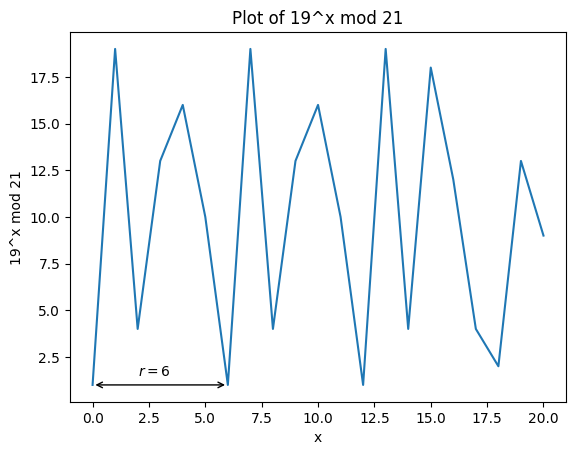

In [79]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(len(a)):
    xval = np.arange(N_value)
    yvals = [np.mod(a[i]**x, N_value) for x in xval]

    fig, ax = plt.subplots()
    ax.plot(xval, yvals, label=f'a = {a[i]}')
    ax.set_xlabel('x')
    ax.set_ylabel(f'{a[i]}^x mod {N_value}')
    ax.set_title(f'Plot of {a[i]}^x mod {N_value}')

    try:
        r = yvals[1:].index(1) + 1
        plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
        plt.annotate(f'$r={r}$', xy=(r/3,1.5))
    except ValueError:
        print('Could not find period, check a < N and have no common factors.')


As we saw above, for N = 21 we obtain a period r = 6. 


Now knowing 3 a values and r, we have to build the swap circuit that maps every controlled moltiplication in the correct result, So i have to build a function named c_amod21 that receives as input power and a and outputs the corrected circuit for this operation  

In [80]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate

dim = 2**N_WORKING_QUBITS

def c_amod21(a: int, power: int):
    # matrice vuota
    U = np.zeros((dim, dim), dtype=complex)
    # mappatura degli stati 0..20
    for y in range(dim):
        if y < N_value:
            j = (pow(a, power, N_value) * y) % N_value 
        else:
            j = y  # lasciamo invariati gli stati fuori da [0,N-1]
        U[j, y] = 1
    # creiamo la gate e la rendiamo controllata
    gate = UnitaryGate(U, label=f"{a}^{power} mod {N_value}")
    return gate.control()

To complete the Shor algorithm, it's necessary the implementation of the QFT dagger, to convert the phase register value from the frequency domain to the real domain and so obtain the r value, fondamental to discover the factorization values of N = 21. 

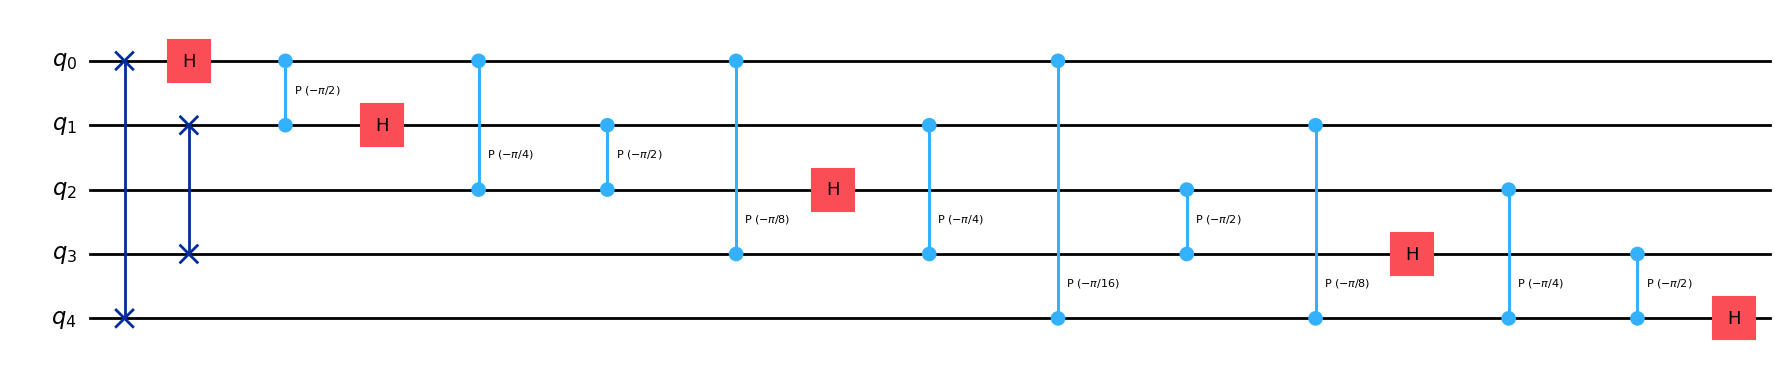

In [81]:

def qft_dagger(n):
    """n-qubit QFTdagger"""
    qc = QuantumCircuit(n)
    for i in range(n//2):
        qc.swap(i, n-i-1)
    for i in range(n):
        for j in range(i):
            qc.cp( -np.pi / 2**(i-j), i, j)
        qc.h(i)
    qc.name = "QFT"
    return qc


qft_dagger(5).draw(fold=-1, output="mpl")

now, lets build the circuit, knowing that for N=21 we require 5 qubits, for the phase register i'll choose to represent it on 8 qubits.

i = 2


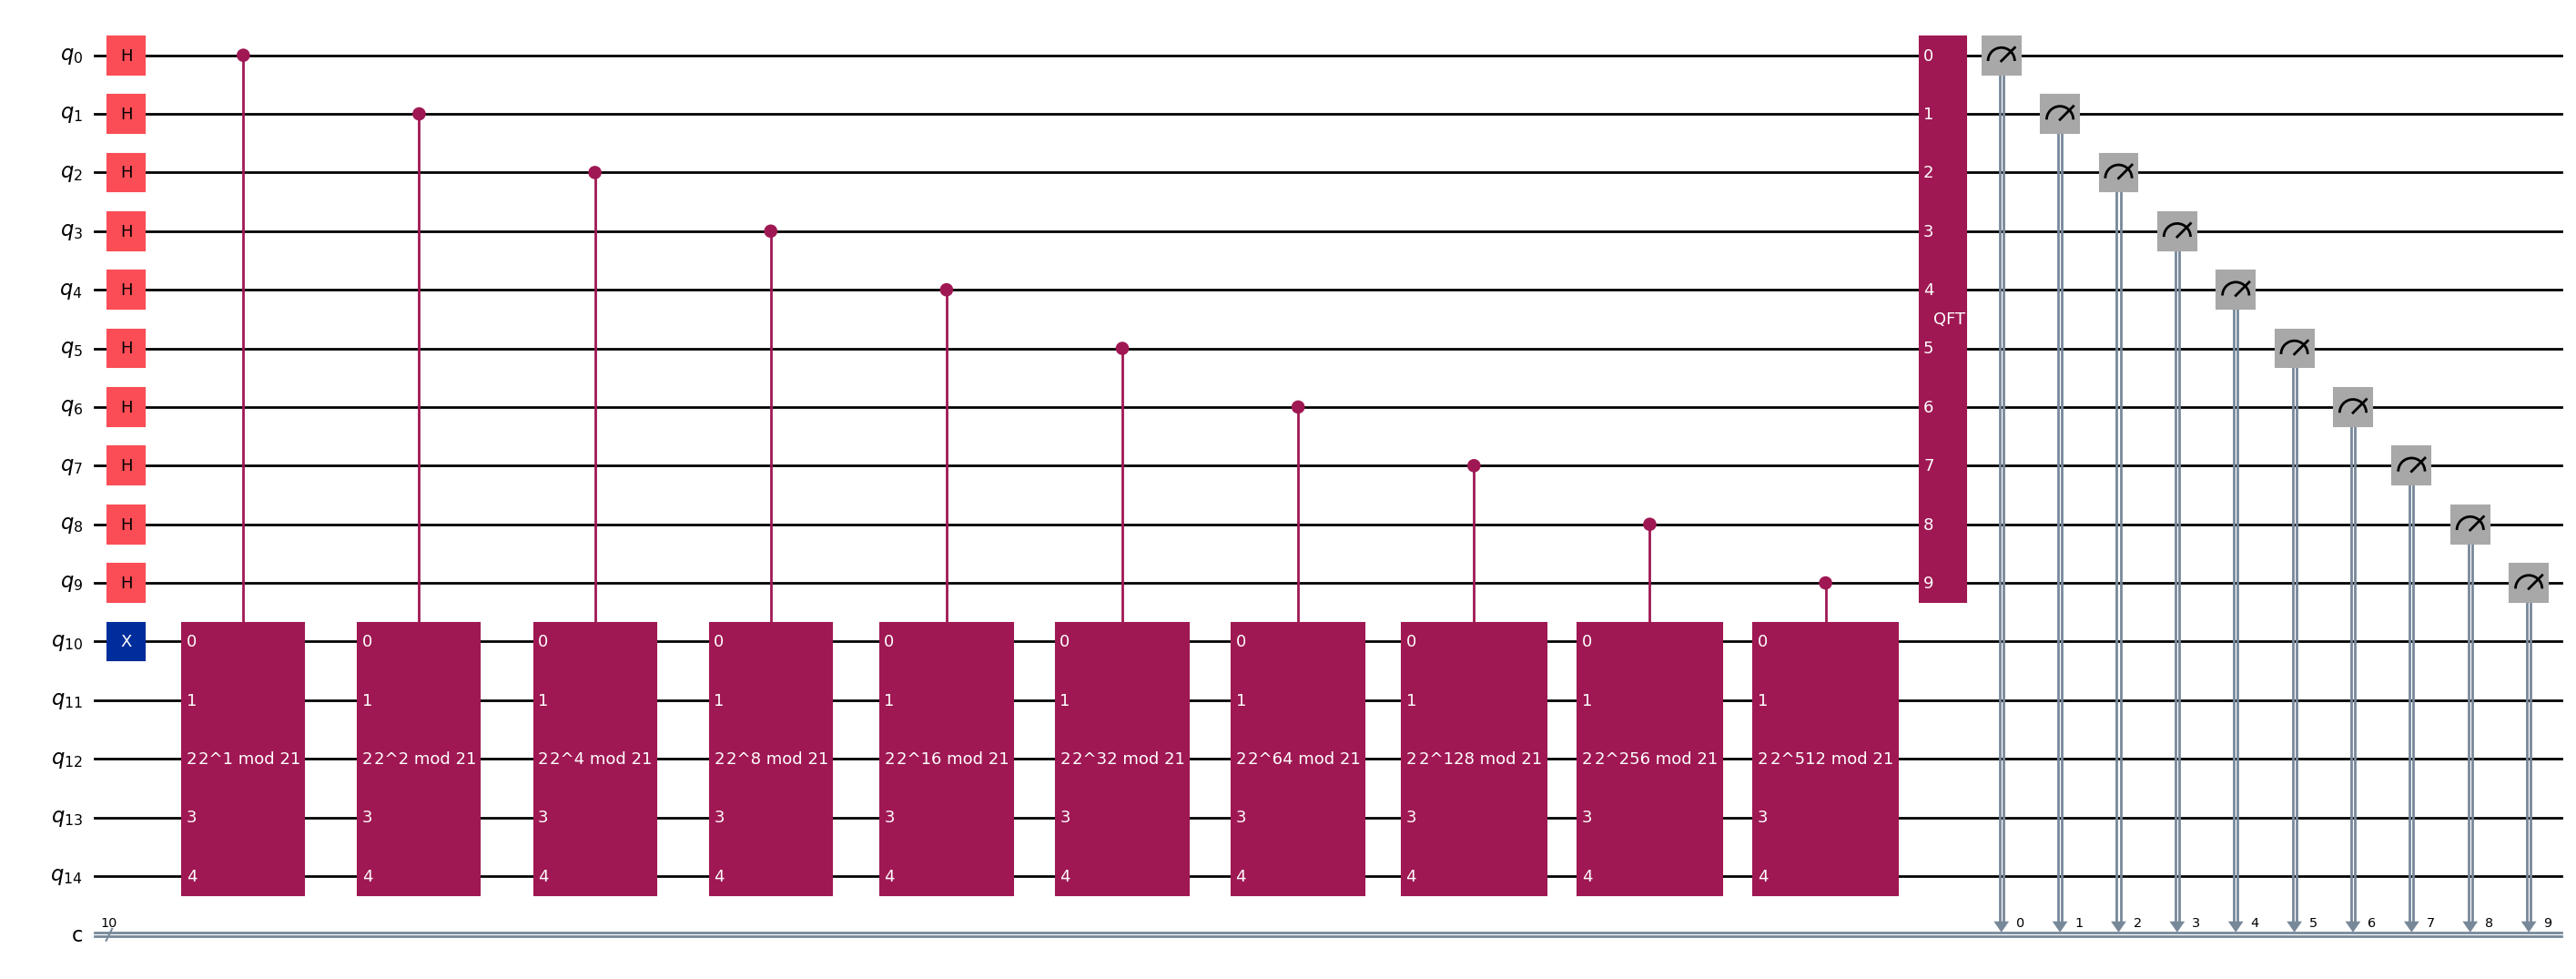

In [82]:
from IPython.display import display

i = a[0] # 2
print(f"i = {i}")
qc = QuantumCircuit(N_PHASE_ESTIMATION_QUBITS + N_WORKING_QUBITS, N_PHASE_ESTIMATION_QUBITS)

# init counting register in |+>
for q in range(N_PHASE_ESTIMATION_QUBITS):
    qc.h(q)
# init aux register in |1>
qc.x(N_PHASE_ESTIMATION_QUBITS)

aux = list(range(N_PHASE_ESTIMATION_QUBITS, N_WORKING_QUBITS + N_PHASE_ESTIMATION_QUBITS))
for ii in range(N_PHASE_ESTIMATION_QUBITS):
    qc.append(c_amod21(i, 2**ii), [ii] + aux)

    # inverse QFT + measure
qc.append(qft_dagger(N_PHASE_ESTIMATION_QUBITS), range(N_PHASE_ESTIMATION_QUBITS))
qc.measure(range(N_PHASE_ESTIMATION_QUBITS), range(N_PHASE_ESTIMATION_QUBITS))

    # show each single circuit
fig = qc.draw(output='mpl', fold=-1)
display(fig)


In [83]:
from qiskit_aer import AerSimulator

In [84]:
backend = AerSimulator()

# Per usare un vero backend IBM Quantum, decommenta e inserisci il tuo token:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<IL_TUO_TOKEN>")
# real_backend = service.least_busy(simulator=False, operational=True)

def run_circuit(circuit, backend):
    """Run the quantum circuit on the specified backend."""
    # Circuits must obey the ISA of the backend.
    # Convert to ISA circuits
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime import SamplerV2 as Sampler

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)

    sampler = Sampler(mode=backend)  # our Primitive
 
    job = sampler.run([isa_circuit])  # parameter is a list of PUBs

    return job
    

def get_counts(job):
    result = job.result()
    counts = result[0].data.c.get_counts()
    return counts


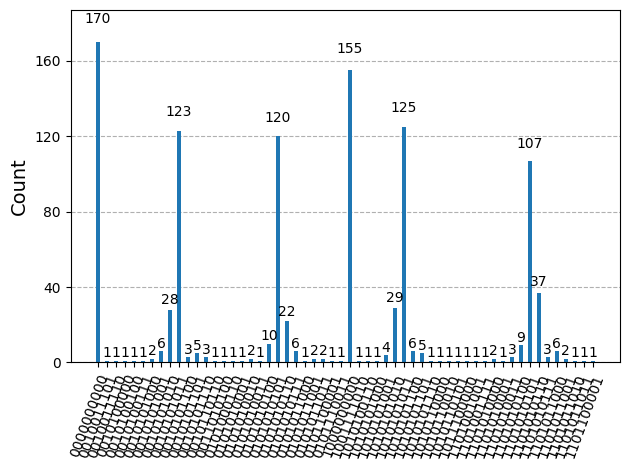

In [85]:
job = run_circuit(qc, backend)
counts = get_counts(job)
plot_histogram(counts)

In [86]:
import pandas as pd
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_PHASE_ESTIMATION_QUBITS)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_PHASE_ESTIMATION_QUBITS} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

               Register Output            Phase
0   1000000000(bin) = 512(dec)  512/1024 = 0.50
1   1101010111(bin) = 855(dec)  855/1024 = 0.83
2   1101010101(bin) = 853(dec)  853/1024 = 0.83
3   0000000000(bin) =   0(dec)    0/1024 = 0.00
4   1010101011(bin) = 683(dec)  683/1024 = 0.67
5   0010101011(bin) = 171(dec)  171/1024 = 0.17
6   1010101001(bin) = 681(dec)  681/1024 = 0.67
7   0101010101(bin) = 341(dec)  341/1024 = 0.33
8   0010101100(bin) = 172(dec)  172/1024 = 0.17
9   1010101101(bin) = 685(dec)  685/1024 = 0.67
10  1010101100(bin) = 684(dec)  684/1024 = 0.67
11  0010101010(bin) = 170(dec)  170/1024 = 0.17
12  1101011000(bin) = 856(dec)  856/1024 = 0.84
13  0101010110(bin) = 342(dec)  342/1024 = 0.33
14  1010101010(bin) = 682(dec)  682/1024 = 0.67
15  1101010110(bin) = 854(dec)  854/1024 = 0.83
16  0101010100(bin) = 340(dec)  340/1024 = 0.33
17  0010101001(bin) = 169(dec)  169/1024 = 0.17
18  1101010100(bin) = 852(dec)  852/1024 = 0.83
19  1101010001(bin) = 849(dec)  849/1024

       Phase Fraction  Guess for r
0   0.500000      1/2            2
1   0.834961      5/6            6
2   0.833008      5/6            6
3   0.000000      0/1            1
4   0.666992      2/3            3
5   0.166992      1/6            6
6   0.665039      2/3            3
7   0.333008      1/3            3
8   0.167969      1/6            6
9   0.668945      2/3            3
10  0.667969      2/3            3
11  0.166016      1/6            6
12  0.835938      5/6            6
13  0.333984      1/3            3
14  0.666016      2/3            3
15  0.833984      5/6            6
16  0.332031      1/3            3
17  0.165039      1/6            6
18  0.832031      5/6            6
19  0.829102      5/6            6
20  0.836914      5/6            6
21  0.156250     3/19           19
22  0.838867    16/19           19
23  0.336914      1/3            3
24  0.169922      1/6            6
25  0.168945      1/6            6
26  0.318359     6/19           19
27  0.344727     7/2

(array([0.01785714, 0.01785714, 0.35714286, 0.        , 0.        ,
        0.28571429, 0.        , 0.        , 0.        , 0.        ,
        0.01785714, 0.        , 0.05357143, 0.        , 0.        ,
        0.        , 0.07142857, 0.01785714, 0.125     , 0.03571429]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21.]),
 <BarContainer object of 20 artists>)

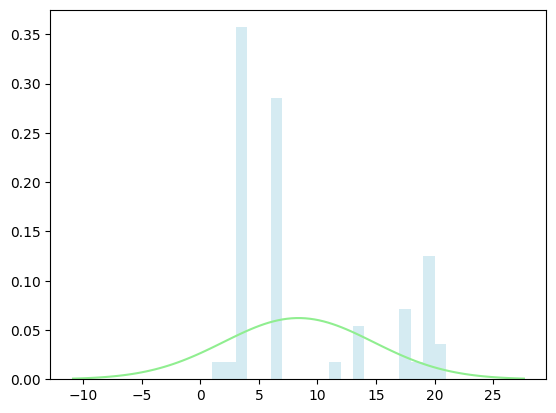

In [87]:
rows = []
r = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(21)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
    r.append(frac.denominator)
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

# scrivi i valori su assi x e y come interi
x = np.arange(len(r))
y = np.array(r)
# calcola la media e la deviazione standard
mean = np.mean(y)
std_dev = np.std(y)
# stampa la gaussiana
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
# crea il grafico
plt.plot(x, y, color='lightgreen', label='Gaussian Fit')
plt.hist(r, bins=20, density=True, alpha=0.5, color='lightblue', label='Measured r')





Saving results

In [88]:
import datetime
now = datetime.datetime.now()
filename = f"IDEALRUN_{now.strftime('%Y-%m-%d_%H-%M-%S')}.csv"
df.to_csv(filename, index=False)

In [89]:
r=6
print(a[0]**(r//2)-1, a[0]**(r//2)+1)
guesses = [gcd(a[0]**(r//2)-1, 21), gcd(a[0]**(r//2)+1, 21)]
print(guesses)

7 9
[7, 3]


# Phase 2: running the circuit in a Noisy environment

# Let's use IBM quantum computers

In [90]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

# Salva il token (una volta sola)
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="83e8bda74bff0f4330398759a4753264ee65bd449b37c563751cf6ddf234ef2c82962c9a8be778919edde162d7ad199490a5638c568b9295e48fd1c59fc7c811")

service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
backend


C:\Users\loren\AppData\Local\Temp\ipykernel_25652\3689663110.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


<IBMBackend('ibm_sherbrooke')>

In [91]:
def run_circuit(circuit, backend):
    """Run the quantum circuit on the specified backend."""
    # Circuits must obey the ISA of the backend.
    # Convert to ISA circuits
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime import SamplerV2 as Sampler

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)

    sampler = Sampler(mode=backend)  # our Primitive
 
    job = sampler.run([isa_circuit])  # parameter is a list of PUBs

    return job

def get_counts(job):
    result = job.result()
    # Get results for the first (and only) PUB
    pub_result = result[0]
    
    # Get counts from the classical register "c".
    counts = pub_result.data.c.get_counts()
    return counts

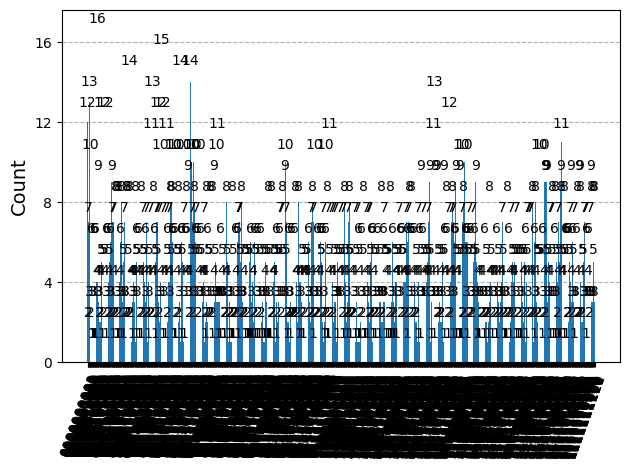

In [92]:
job = run_circuit(qc, backend)
counts = get_counts(job)
plot_histogram(counts)

In [93]:
import pandas as pd
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_PHASE_ESTIMATION_QUBITS)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_PHASE_ESTIMATION_QUBITS} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)



                Register Output            Phase
0    1101010111(bin) = 855(dec)  855/1024 = 0.83
1    0000000000(bin) =   0(dec)    0/1024 = 0.00
2    0001010100(bin) =  84(dec)   84/1024 = 0.08
3    0000000100(bin) =   4(dec)    4/1024 = 0.00
4    0011000100(bin) = 196(dec)  196/1024 = 0.19
..                          ...              ...
967  0110110101(bin) = 437(dec)  437/1024 = 0.43
968  0001010111(bin) =  87(dec)   87/1024 = 0.08
969  1011101011(bin) = 747(dec)  747/1024 = 0.73
970  1001101001(bin) = 617(dec)  617/1024 = 0.60
971  0100011001(bin) = 281(dec)  281/1024 = 0.27

[972 rows x 2 columns]


        Phase Fraction  Guess for r
0    0.834961      5/6            6
1    0.000000      0/1            1
2    0.082031     1/12           12
3    0.003906      0/1            1
4    0.191406     4/21           21
..        ...      ...          ...
967  0.426758      3/7            7
968  0.084961     1/12           12
969  0.729492     8/11           11
970  0.602539      3/5            5
971  0.274414     3/11           11

[972 rows x 3 columns]
Data saved to IBMRUN_2_date_2025-04-26_08-15-05.csv


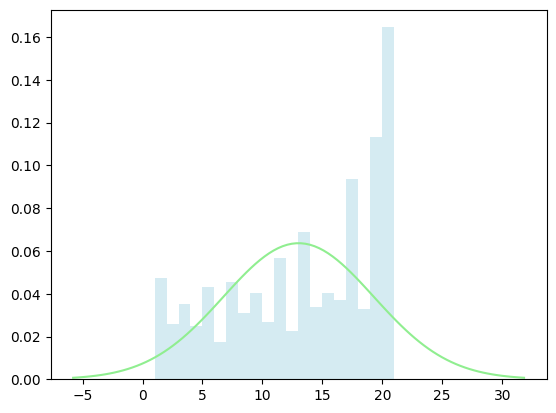

In [94]:
rows = []
r = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(21)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
    r.append(frac.denominator)
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

# scrivi i valori su assi x e y come interi
x = np.arange(len(r))
y = np.array(r)
# calcola la media e la deviazione standard
mean = np.mean(y)
std_dev = np.std(y)
# stampa la gaussiana
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)
# crea il grafico
plt.plot(x, y, color='lightgreen', label='Gaussian Fit')
plt.hist(r, bins=20, density=True, alpha=0.5, color='lightblue', label='Measured r')

#salva tutti i dati in un file csv con la data odierna e l'ora di esecuzione
import datetime
now = datetime.datetime.now()
filename = f"IBMRUN_2_date_{now.strftime('%Y-%m-%d_%H-%M-%S')}.csv"
df.to_csv(filename, index=False)
print(f"Data saved to {filename}")


In [95]:
r=6
print(a[0]**(r//2)-1, a[0]**(r//2)+1)
guesses = [gcd(a[0]**(r//2)-1, 21), gcd(a[0]**(r//2)+1, 21)]
print(guesses)

7 9
[7, 3]


# Performance evaluation
now, to evaluate the results obtained from both the experiment, i'll find the average number of shots required to find the right period to factor 21

In [104]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# Parametri del problema
a = 2
N = 21

def plot_data(df):
    success_shot_counts = []  
    current_shot_count = 0   

    for idx, row in df.iterrows():
        r = row['Guess for r']
        current_shot_count += 1
    
        if r % 2 != 0 or r == 0:  # Serve che r sia pari e diverso da zero
            continue
    
    # Calcolo dei due GCD
        gcd1 = math.gcd(pow(a, r//2) - 1, N)
        gcd2 = math.gcd(pow(a, r//2) + 1, N)
    
        if gcd1 in [3, 7] or gcd2 in [3, 7]:
            success_shot_counts.append(current_shot_count)
            current_shot_count = 0  # Reset contatore dopo un successo

    # Calcolo della media
    if success_shot_counts:
        average_shots = sum(success_shot_counts) / len(success_shot_counts)
    else:
        average_shots = float('inf')  # Nessun successo trovato

    average_shots, success_shot_counts


    plt.figure(figsize=(10,6))  
    plt.hist(success_shot_counts, bins=range(1, max(success_shot_counts)+2), edgecolor='black', align='left')
    plt.axvline(average_shots, color='red', linestyle='dashed', linewidth=1, label=f'Media: {average_shots:.2f}')
    plt.title('Distribuzione del numero di tentativi per fattorizzare 21', fontsize=16)
    plt.xlabel('Tentativi prima del successo', fontsize=14)
    plt.ylabel('Frequenza', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(1, max(success_shot_counts)+1))
    plt.show()



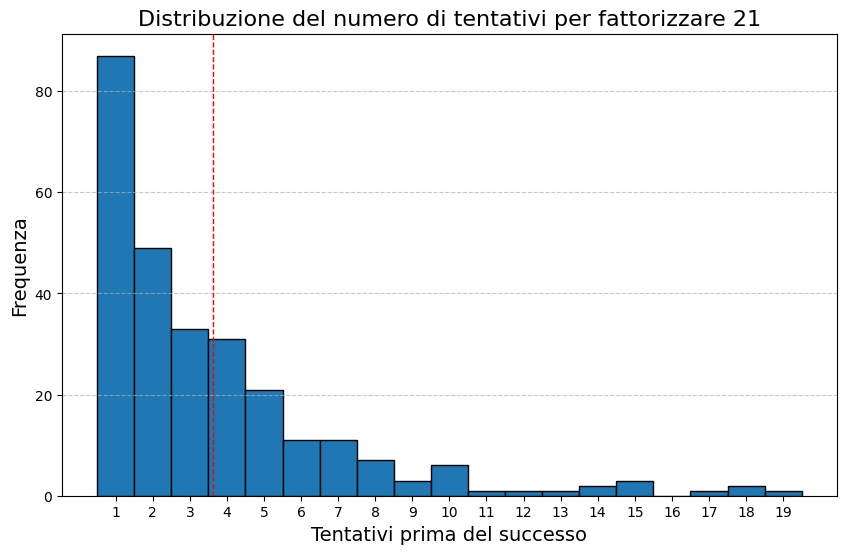

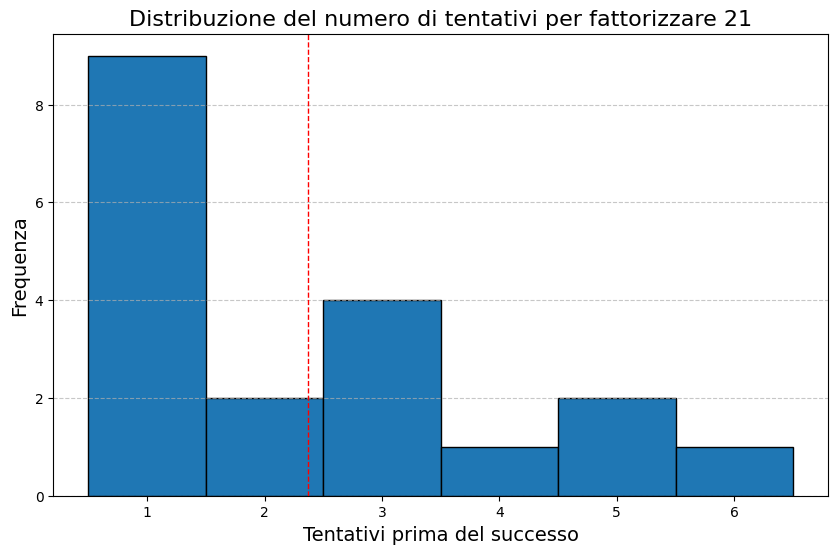

In [105]:
df = pd.read_csv("IBMRUN_date_2025-04-26_08-02-50.csv")
plot_data(df)

df_2 = pd.read_csv("IDEALRUN_2025-04-26_08-11-08.csv") 
plot_data(df_2)